### Confidence Intervals Predictions with quantile-method  

In this notebook we will make,compare and evaluate confidence intervals for time series forecasting task.

In [1]:
import fbprophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from fbprophet import Prophet

/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# date uploading
df = pd.read_csv('ts study 1.txt')
d = df[df['label'] == 'traffic_volume'].drop('label',axis=1).rename(columns = {'datetime':'ds', 'value':'y'})

In [3]:
d

,ds,y
17520,2016-10-01 00:00:00,1195.0
17521,2016-10-01 01:00:00,776.0
17522,2016-10-01 02:00:00,666.0
17523,2016-10-01 03:00:00,448.0
17524,2016-10-01 04:00:00,512.0
...,...,...
35035,2018-09-30 19:00:00,3543.0
35036,2018-09-30 20:00:00,2781.0
35037,2018-09-30 21:00:00,2159.0
35038,2018-09-30 22:00:00,1450.0


In [4]:
# train and test series
train  = d[:-336]
test = d[-336:]

We have a daily and weekly periodical time series of traffic volume observations. The typical behaviour of this
ts is plotted below:

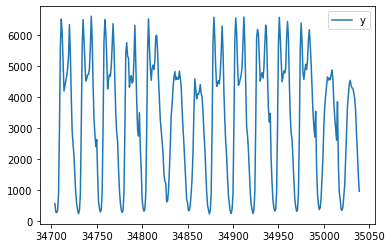

In [5]:
test.plot();

We take some model that performs well on this ts and use it.

In [6]:
model = Prophet(weekly_seasonality = True, daily_seasonality = True)
model.fit(train);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1397.23
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       28390.7   0.000823447       95.7467           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       28402.3    0.00634046       480.417           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251         28405   7.80721e-05       128.426   2.875e-07       0.001      373  LS failed, Hessian reset 
     265       28405.7    3.8712e-05       79.5181    3.54e-07       0.001      428  LS failed, Hessian reset 
     281       28406.1    0.00017309       218.037   1.793e-06       0.001      490  LS failed, Hessian reset 
     299       28406.6   0.000364585       81.5777           1           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Now we are start working on the residuals of the model on training set. 

In [7]:
# create residuals of the model on the trainig set
train_preds = model.predict(train)['yhat']
train_preds = pd.Series(np.array(train_preds),index = range(17520,34704))

resids = train_preds-train['y']

/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Plot histogramm of the residuals. As wee see, the distribution of the residuals below does not seem to be normal, since it has to sharp mode at 0 and non-symmetricals positive and negative parts. But, this does not affect our approach.

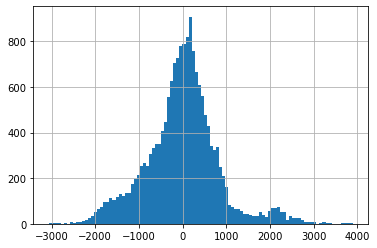

In [8]:
resids.hist(bins=100);

In [9]:
resids.std()

842.5505602727231

We take quantiles of the distribution of the residuals below

In [10]:
# take quantile of the residuals
up_quantile = np.quantile(resids, 0.925)
low_quantile = np.quantile(resids, 0.075)

As low bound point of our confidence interval we take low_quantile + predicions,
for upper bound we take upper_quantile +predictions. Here we take default facebook predictions + facebook confidence intervals

In [11]:
# predictions
future = model.make_future_dataframe(periods = 336, freq = 'H',include_history = False)
all_pred = model.predict(future)
pred = all_pred['yhat']

lower = all_pred['yhat_lower']
upper = all_pred['yhat_upper']

up_conf_int = pred+up_quantile
low_conf_int = pred+low_quantile

/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/data/home/jasnovidov/.conda/envs/grisha/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Next we plot several plots, that show performance of our and fb results.

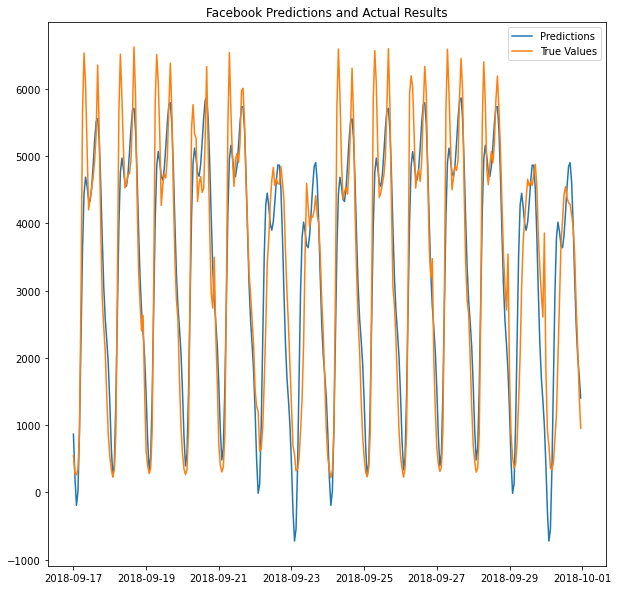

In [12]:
#Plotting the results; from this plot we see that the facebook model performs well

fig,ax = plt.subplots()
ax.plot(future['ds'], pred, label = 'Predictions')
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook Predictions and Actual Results')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

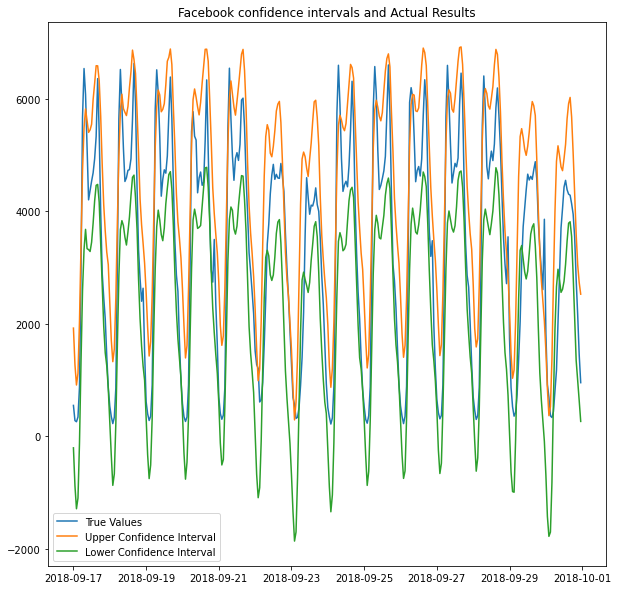

In [13]:
# here we plot facebook confidence intervals and actual values

fig,ax = plt.subplots()
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook confidence intervals and Actual Results')
ax.plot(future['ds'], upper, label = 'Upper Confidence Interval')
ax.plot(future['ds'], lower,label =  'Lower Confidence Interval')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

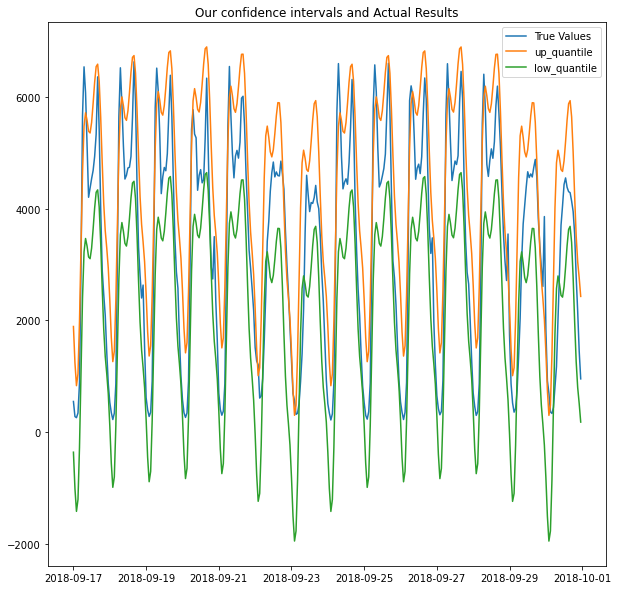

In [14]:
# here we see our confidence intervals and actual values
fig,ax = plt.subplots()
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Our confidence intervals and Actual Results')
ax.plot(future['ds'],up_conf_int,label = 'up_quantile')
ax.plot(future['ds'],low_conf_int,label = 'low_quantile')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

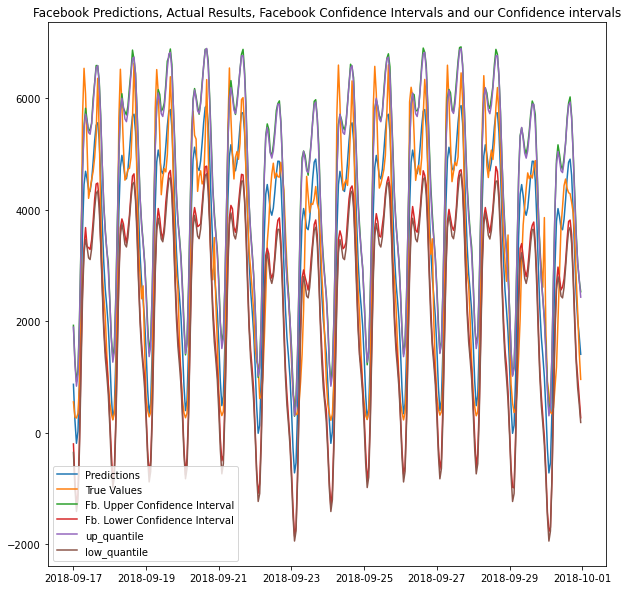

In [15]:
# Here we see everything on the same plot

fig,ax = plt.subplots()
ax.plot(future['ds'], pred, label = 'Predictions')
ax.plot(future['ds'], test['y'], label = 'True Values')
ax.set_title('Facebook Predictions, Actual Results, Facebook Confidence Intervals and our Confidence intervals')
ax.plot(future['ds'], upper, label = 'Fb. Upper Confidence Interval')
ax.plot(future['ds'], lower,label =  'Fb. Lower Confidence Interval')
ax.plot(future['ds'],up_conf_int,label = 'up_quantile')
ax.plot(future['ds'],low_conf_int,label = 'low_quantile')
fig.set(figwidth = 10, figheight = 10)
plt.legend();

Here we numerically evaluate our results. We create a metric that can compare perforamce of the confidence
intervals

In [16]:
# This is the prototype of metrics that evaluates robustness of confidence intervals. 
def interval_metric(values,up, low):
    values = np.array(values)
    up = np.array(up)
    low = np.array(low)
    lv = len(values)
    if lv != len(up) or lv != len(low):
        print('ERROR! Arrays have different length!')
    for i in range(lv):
        if up[i]<low[i]:
            print('ERROR! Confidence intervals are not correct!')
    else:    
        u = 0
        l = 0
        for i in range(lv):
            if values[i] > up[i]:
                u +=1
            if values[i] < low[i]:
                l+=1
        gap = up-low
        average_gap = gap.mean()
        ans = {'total_upper_error': u,
               'total_lower_error': l,
               'total_error' : l+u,
               'percent_upper_error':u/lv,
               'percent_lower_error': l/lv,
               'percent_error': (u+l)/lv,
               'average_gap': average_gap}
        
        return ans

In [17]:
interval_metric(test['y'],upper,lower)

{'total_upper_error': 35,
 'total_lower_error': 16,
 'total_error': 51,
 'percent_upper_error': 0.10416666666666667,
 'percent_lower_error': 0.047619047619047616,
 'percent_error': 0.15178571428571427,
 'average_gap': 2156.385812325436}

In [18]:
interval_metric(test['y'],up_conf_int,low_conf_int)

{'total_upper_error': 37,
 'total_lower_error': 14,
 'total_error': 51,
 'percent_upper_error': 0.11011904761904762,
 'percent_lower_error': 0.041666666666666664,
 'percent_error': 0.15178571428571427,
 'average_gap': 2247.5280602311905}

In [19]:
#Some metrics of fb predictions
mae(test['y'], pred), np.sqrt(mse(test['y'],pred)), test['y'].std()

(598.8701349273575, 803.7736897468992, 1965.7025461628507)